In [12]:
import numpy as np
import scipy as sp
import matplotlib.pylab as plt
rng = np.random.default_rng()
import torch
from torch import nn
import numpy as np
from torch import optim
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader, TensorDataset

In [13]:
def generate_pinwheel(*, num: int, rng: np.random.Generator) -> np.ndarray:
    # https://github.com/Formulator/Spiral/blob/master/PyTorch_Spiral_DataLoader.ipynb
    D = 2 # dimensionality
    K = 3 # number of classes
    N = num // K  # note: we will not generate exactly num datapoints unless K divides num
    X = np.zeros((N*K,D))
    y = np.zeros(N*K, dtype='uint8')
    for j in range(K):
      ix = range(N*j,N*(j+1))
      r = np.linspace(0.0,1,N) # radius
      t = np.linspace(j*4,(j+1)*4,N) + rng.standard_normal(N)*0.2 # theta
      X[ix] = np.c_[r*np.sin(t), r*np.cos(t)]
    return X
pin = generate_pinwheel(num=2000, rng=rng)

In [6]:
def generate_checkerboard(*, num: int, rng: np.random.Generator) -> np.ndarray:
    # https://github.com/malbergo/stochastic-interpolants/blob/main/notebooks/checker-mirror.ipynb
    x1 = rng.uniform(size=num) * 4 - 2
    x2_ = rng.uniform(size=num) - rng.choice([0, 1], size=(num,)) * 2
    x2 = x2_ + (np.floor(x1) % 2)
    x = np.hstack([x1[:, None], x2[:, None]]) * 2
    return x
chk = generate_checkerboard(num=2000, rng=rng)

In [7]:
chk.shape

(2000, 2)

In [8]:

tensor_data = torch.tensor(chk, dtype=torch.float32)
data_loader = DataLoader(TensorDataset(tensor_data), batch_size=32, shuffle=True)

device = torch.device("mps")
device

device(type='mps')

In [14]:
class Generator(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(Generator, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, 128),
            nn.BatchNorm1d(128),
            nn.ReLU(True),
            nn.Linear(128, 512),
            nn.BatchNorm1d(512),
            nn.ReLU(True),
            nn.Linear(512, output_dim),
        )

    def forward(self, x):
        return self.net(x)

class Discriminator(nn.Module):
    def __init__(self, input_dim):
        super(Discriminator, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, 512),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Dropout(0.1),
            nn.Linear(512, 128),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Dropout(0.1),
            nn.Linear(128, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        return self.net(x)

In [7]:
epochs = 1500
epoch_losses = []
d_losses = []
g_losses = []
generator = Generator(300, 2).to(device)
discriminator = Discriminator(2).to(device)

In [12]:
g_optimizer = optim.Adam(generator.parameters(), lr=0.00005)
d_optimizer = optim.Adam(discriminator.parameters(), lr=0.00005)

In [13]:
for epoch in range(1000):
    for real_data in data_loader:
        real_data = real_data[0].to(device)

        z = torch.randn(real_data.size(0), 300, device=device)
        fake_data = generator(z)

        d_real = discriminator(real_data)
        d_fake = discriminator(fake_data.detach())
        d_loss = -torch.mean(torch.log(d_real) + torch.log(1 - d_fake))

        d_optimizer.zero_grad()
        d_loss.backward()
        d_optimizer.step()

        g_fake = discriminator(fake_data)
        g_loss = -torch.mean(torch.log(g_fake))

        g_optimizer.zero_grad()
        g_loss.backward()
        g_optimizer.step()

    if (epoch + 1) % 100 == 0:
        epoch_losses.append(epoch+1500 + 1)
        d_losses.append(d_loss.item())
        g_losses.append(g_loss.item())
        print(f'Epoch {epoch+1}/{epochs}, D Loss: {d_loss.item():.4f}, G Loss: {g_loss.item():.4f}')

Epoch 100/1500, D Loss: 1.3216, G Loss: 0.7235
Epoch 200/1500, D Loss: 1.3756, G Loss: 0.6645
Epoch 300/1500, D Loss: 1.3649, G Loss: 0.7201
Epoch 400/1500, D Loss: 1.3302, G Loss: 0.7684
Epoch 500/1500, D Loss: 1.4257, G Loss: 0.6933
Epoch 600/1500, D Loss: 1.3420, G Loss: 0.6522
Epoch 700/1500, D Loss: 1.3757, G Loss: 0.6628
Epoch 800/1500, D Loss: 1.3854, G Loss: 0.7001
Epoch 900/1500, D Loss: 1.3477, G Loss: 0.7500
Epoch 1000/1500, D Loss: 1.3939, G Loss: 0.6816


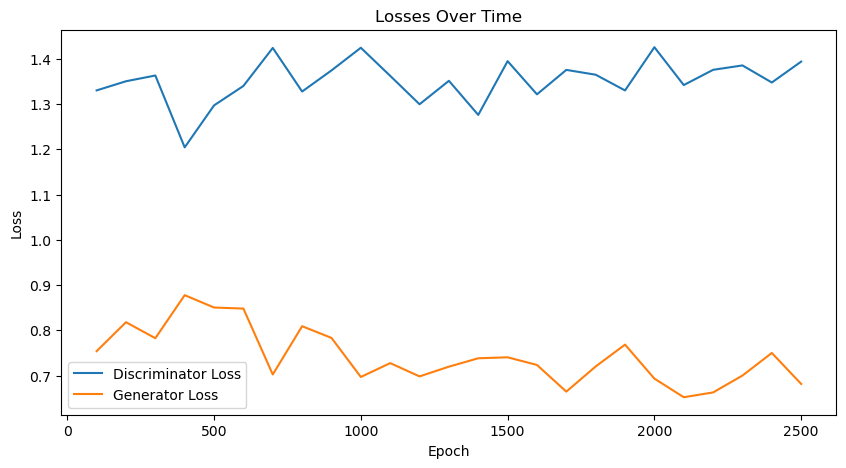

In [14]:
plt.figure(figsize=(10, 5))
plt.plot(epoch_losses, d_losses, label='Discriminator Loss')
plt.plot(epoch_losses, g_losses, label='Generator Loss')
plt.title('Losses Over Time')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

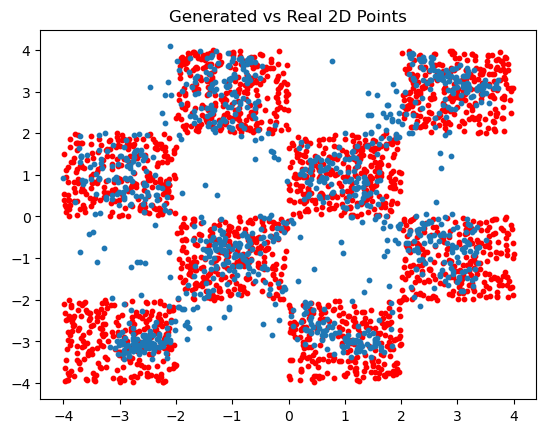

In [15]:
z = torch.randn(1000, 300, device=device)
generated_points = generator(z).detach().cpu().numpy()
plt.scatter(chk[:, 0], chk[:, 1], s=10, c='red') 
plt.scatter(generated_points[:, 0], generated_points[:, 1], s=10)
plt.title('Generated vs Real 2D Points')
plt.show()

In [16]:
torch.save(generator, 'GAN_check_gen.pth')
torch.save(Discriminator, 'GAN_check_disc.pth')

In [15]:
model = torch.load('GAN_check_gen.pth')


Generator(
  (net): Sequential(
    (0): Linear(in_features=300, out_features=128, bias=True)
    (1): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Linear(in_features=128, out_features=512, bias=True)
    (4): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): Linear(in_features=512, out_features=2, bias=True)
  )
)

In [16]:
z = torch.randn(1000, 300, device=device)
generated_points = model(z).detach().cpu().numpy()
np.save("GAN_check.npy",generated_points)